In [28]:
from pyomo.environ import *
from pyomo.dae import *

#Ampl Car Example
#
# Shows how to convert a minimize final time optimal control problem
# to a format pyomo.dae can handle by removing the time scaling from
# the ContinuousSet.
#
# min tf
# dxdt = 0
# dvdt = a-R*v^2
# x(0)=0; x(tf)=L
# v(0)=0; v(tf)=0
# -3<=a<=1
 
from pyomo.environ import *
from pyomo.dae import *
 
m = ConcreteModel()
 
m.R = Param(initialize=0.001) #  Friction factor
m.L = Param(initialize=100.0) #  Final position
 
m.tau = ContinuousSet(bounds=(0,1)) # Unscaled time
m.time = Var(m.tau) # Scaled time
m.tf = Var()
m.x = Var(m.tau, bounds=(0,m.L+50))
m.v = Var(m.tau, bounds=(0,None))
m.a = Var(m.tau, bounds=(-3.0,1.0), initialize=0)
 
m.dtime = DerivativeVar(m.time)
m.dx = DerivativeVar(m.x)
m.dv = DerivativeVar(m.v)
 
m.obj = Objective(expr=m.tf)

m.maxvel = Constraint(m.tau, rule=lambda m,i: m.v[i] <= 10)
 
def _ode1(m,i):
    if i == 0 :
        return Constraint.Skip
    return m.dx[i] == m.tf * m.v[i]
m.ode1 = Constraint(m.tau, rule=_ode1)
 
def _ode2(m,i):
    if i == 0 :
        return Constraint.Skip
    return m.dv[i] == m.tf*(m.a[i] - m.R*m.v[i]**2)
m.ode2 = Constraint(m.tau, rule=_ode2)
 
def _ode3(m,i):
    if i == 0:
        return Constraint.Skip
    return m.dtime[i] == m.tf
m.ode3 = Constraint(m.tau, rule=_ode3)
 
def _init(m):
    yield m.x[0] == 0
    yield m.x[1] == m.L
    yield m.v[0] == 0
    yield m.v[1] == 0
    yield m.time[0] == 0
m.initcon = ConstraintList(rule=_init)
 
discretizer = TransformationFactory('dae.finite_difference')
discretizer.apply_to(m,nfe=50,scheme='BACKWARD')
 
solver = SolverFactory('ipopt')
solver.solve(m,tee=True)
 

Ipopt 3.12.8: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      905
Number of nonzeros in inequality constraint Jacobian.:       51
Number of nonzeros in Lagrangian Hessian.............:      150

Total number of variables............................:      354
                     variables with only lower bounds:       51
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 356, 'Number of variables': 354, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.12.8\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.17873883247375488}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

final time =  16.75


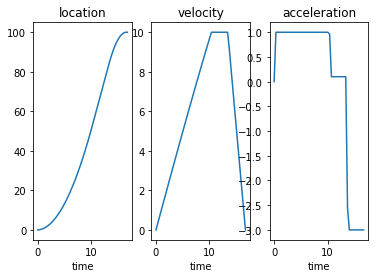

In [29]:
print("final time = %6.2f" %(value(m.tf)))
  
time = [value(m.time[i]) for i in m.tau]
x = [value(m.x[i]) for i in m.tau]
v = [value(m.v[i]) for i in m.tau]
a = [value(m.a[i]) for i in m.tau]
   
import matplotlib.pyplot as plt
 
plt.subplot(131)
plt.plot(time,x,label='x')
plt.title('location')
plt.xlabel('time')
 
plt.subplot(132)
plt.plot(time,v,label='v')
plt.xlabel('time')
plt.title('velocity')
 
plt.subplot(133)
plt.plot(time,a,label='a')
plt.xlabel('time')
plt.title('acceleration')
 
plt.show()